#Week 3 Project

Jiwei Xia

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import scipy
from scipy.stats import pearsonr
from bisect import bisect_left

In [2]:
# upload documents, run this only when using Google Colab
from google.colab import files
uploaded1 = files.upload()

Saving DailyReturn.csv to DailyReturn.csv


In [3]:
# read the data
my_data = np.genfromtxt('DailyReturn.csv', delimiter=',').T
my_data = np.delete(my_data, 0, 0)
my_data = np.delete(my_data, 0, 1)
my_data = np.matrix(np.fliplr(my_data))

## Problem 1

QUESTION: Use the stock returns in DailyReturen.csv for this problem. DailyReturen.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.

Create a routine for calculating exponentially weighted covariance matrix.

Vary $λ \in (0,1)$. Use PCA and plot the cumulative variance explained by each eigenvalue for each $\lambda$ chosen.

What does this tell us about values of $\lambda$ and the effect i has on the covariance matrix?

SOLUTION:

1.1 Exponentially weighted covariance matrix

To calculate the exponentially weighted covariance matrix, we will first calculate the weights using this equation:
$$w_{t-1} = (1 - \lambda)\lambda^{i-1}$$
$$\widehat{w_{t-1}} = \frac{w_{t-1}}{\sum_{j=1}^{n}w_{t-j}}$$
Then we will multiply the error matrices with the weights to get the covariance matrix.

In [25]:
# calculate exponential weights
def calculate_exponential_weights(lags, lamb):
  weights = []
  for i in range(1, lags + 1):
    weight = (1 - lamb) * lamb ** (i - 1)
    weights.append(weight)
  weights = np.array(weights)
  normalized_weights = weights / weights.sum()
  return normalized_weights

# calculate exponentially weighted covariance matrix
def calculate_ewcov(data, lamb):
  weights = calculate_exponential_weights(data.shape[1], lamb)
  error_matrix = data - data.mean(axis=1)
  ewcov = error_matrix @ np.diag(weights) @ error_matrix.T
  return ewcov

1.2 Calculate the PCA cumulative explained variance ratio.

In [36]:
# calculate the PCA cumulative explained variance ratio.
def PCA_cumulative_evr(cov_matrix):
  eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

  # sort the eigen values and eigen vectors in decsending order
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalues = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  # explained variance ratio
  evr = sorted_eigenvalues / sorted_eigenvalues.sum()
  cumulative_evr = evr.cumsum()
  cumulative_evr[-1] = 1
     
  return cumulative_evr

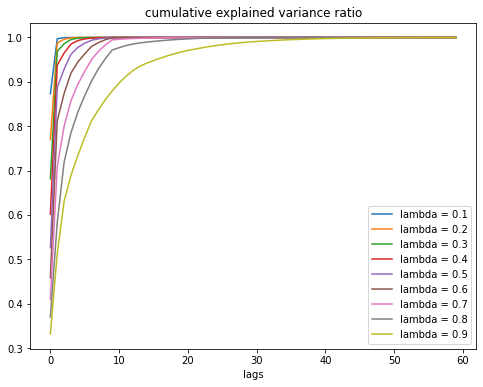

In [72]:
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5,
           0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(8, 6))
for i, lamb in enumerate(lambdas):
  cov = calculate_ewcov(my_data, lamb)
  cumulative_evr = PCA_cumulative_evr(cov)
  plt.plot(np.arange(my_data.shape[1]), cumulative_evr[:my_data.shape[1]], label=f"lambda = {lambdas[i]}")

plt.xlabel('lags')
plt.title("cumulative explained variance ratio")
plt.legend()
plt.show()

From the plot, we can see that when lambda is small, the exponentially weighted covariance matrix puts more weight on current data, and decays quickly as lags increase. As lambda becomes larger, the covariance matrix is more evenly distributed throughout the time duration, and decays slowly towards the maximum lag.

# Problem 2

QUESTION: Copy the chol_psd(), and near_psd() functions from the course repository = inplement in your programming language of the class.

Implement Higham's 2002 nearest psd correlation function.

Generate a non-psd correlation matrix that is 500x500. Use the code in class:

```
n = 500
sigma = fill(0.9, (n,n))
for i in 1:n:
  signma[i,i] = 1.0
and 
sigma[1,2] = 0.07357
sigma[2,1] = 0.07357
```



Use near_psd() and Higham's method to fix the matrix. Confirm the matrix is now PSD.

Compare the results o both using the Frobenius Norm. Compare the run time between the two. How does the run time of each functin compare as N increases?

Based on the above, discuss the pros and cons of each method and when you would use each.

2.1 Implement chol_psd

In [7]:
# Calculate Cholesky root.
def chol_psd(root, a):
  n = a.shape[1]
  # loop over columns
  for j in range(n):
    s = 0.0
    # if we are not on the first column, calculate the dot product of the preceeding row values.
    if j > 0:
      s =  root[j,:j] @ root[j,:j].T
    # Diagonal Element
    temp = a[j,j] - s
    if -1e-8 <= temp <= 0:
      temp = 0.0
    root[j,j] = np.sqrt(temp)
    # Check for the 0 eigan value.  Just set the column to 0 if we have one
    if root[j,j] == 0.0:
      root[j,j:n-1] = 0.0
    else:
      # update off diagonal rows of the column
      for i in range(j+1, n):
        s = root[i,:j] @ root[j,:j].T
        root[i,j] = (a[i,j] - s) / root[j,j]
  return root

2.2 Implement near_psd

In [8]:
# Rebonato and Jackel
def near_psd(a, epsilon=0.0):
  n = a.shape[1]

  invSD = None
  out = copy.deepcopy(a)

  # calculate the correlation matrix if we got a covariance
  if (np.sum(np.isclose(1.0, np.diag(out))) != n):
    invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
    out = invSD @ out @ invSD
  
  # SVD, update the eigen value and scale
  vals, vecs = np.linalg.eigh(out)
  vals = np.maximum(vals, epsilon)
  T = 1.0 / (np.square(vecs) @ vals)
  T = np.diagflat(np.sqrt(T))
  l = np.diag(np.sqrt(vals))
  B = T @ vecs @ l
  out = B @ B.T

  # Add back the variance
  if invSD != None:
    invSD = np.diag(1.0 / np.diag(invSD))
    out = invSD @ out @ invSD

  return out

2.3 Implement Higham’s 2002 nearest psd correlation function.

In [63]:
def frobenius_norm(matrix):
  return np.sqrt(np.square(matrix).sum())

def projection_u(matrix):
  out = copy.deepcopy(matrix)
  np.fill_diagonal(out, 1.0)
  return out

def projection_s(matrix, epsilon=0.0):
  vals, vecs = np.linalg.eigh(matrix)
  vals = np.maximum(vals, epsilon)
  return vecs @ np.diag(vals) @ vecs.T

# Higham
def higham_psd(a, max_iter=100, tol=1e-8):
  # delta_S0 = 0, Y0 = A, gamma0 = max float
  delta_s = 0.0
  y = a
  prev_gamma = np.inf

  # loop k iterations
  for i in range(max_iter):
    r = y - delta_s
    x = projection_s(r)
    delta_s = x - r
    y = projection_u(x)
    gamma = frobenius_norm(y - a)

    if abs(gamma - prev_gamma) < tol:  
      break
    prev_gamma = gamma

  return y

2.4 Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.

In [10]:
def is_psd(matrix, tol=1e-7):
   return np.all(np.linalg.eigvals(matrix) >= -tol)

In [64]:
n = 500
sigma = np.matrix(np.full((n, n), 0.9))
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

near_psd_matrix = near_psd(sigma)
print(is_psd(near_psd_matrix))
higham_psd_matrix = higham_psd(sigma)
print(is_psd(higham_psd_matrix))

True
True


We can confirm that both matrices fixed by near_psd and higham_psd are now psd matrices.

2.5 Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases?

In [65]:
print(frobenius_norm(near_psd_matrix - sigma))
print(frobenius_norm(higham_psd_matrix - sigma))

0.6275226557679096
0.08964798746820993


By comparing the Frobenius Norm, we can see that the result from higham_psd function is more accurate than the one from near_psd.

In [66]:
def generate_non_psd_matrix(n):
  sigma = np.matrix(np.full((n, n), 0.9))
  np.fill_diagonal(sigma, 1)
  sigma[0, 1] = 0.7357
  sigma[1, 0] = 0.7357
  return sigma

def near_psd_runtime(n):
  sigma = generate_non_psd_matrix(n)
  start_t = time.time()
  near_psd_matrix = near_psd(sigma)
  end_t = time.time()
  return end_t - start_t

def higham_psd_runtime(n):
  sigma = generate_non_psd_matrix(n)
  start_t = time.time()
  near_psd_matrix = higham_psd(sigma)
  end_t = time.time()
  return end_t - start_t

In [67]:
t1 = near_psd_runtime(100)
t2 = higham_psd_runtime(100)
print(t1)
print(t2)
print(t2 / t1)

0.008479118347167969
0.05949234962463379
7.016336745023057


In [68]:
t1 = near_psd_runtime(500)
t2 = higham_psd_runtime(500)
print(t1)
print(t2)
print(t2 / t1)

0.0787503719329834
1.415074348449707
17.969113208175525


In [69]:
t1 = near_psd_runtime(900)
t2 = higham_psd_runtime(900)
print(t1)
print(t2)
print(t2 / t1)

0.3177032470703125
6.716566801071167
21.14100772657413


Looking at the run time, we can see that higham_psd takes much longer to compute than near_psd. As N increases, the ratio between the run times of these 2 functions would also increase.

Based on the results above, the near_psd method is less accurate, but runs very fast, especially when N is small. The higham_psd method is more accurate, but runs very slowly, and the run time increases even more as N increases.

When we have a strict requirement on accuracy and don't care about run time, we can use higham_psd. When the accuracy requirement is more relaxed, and the computational resource is more limited, especially on a smaller matrix, we would choos near_psd.

# Problem 3

Using DailyReturn.csv

Implement a multivariate normal simulation that allows for simulation direactly from a covariance matrix or using PCA with and optional

In [62]:
# calculate correlation matrix
def calculate_corr(cov):
  std = np.sqrt(np.diag(cov))
  inversed_std = np.diag(1 / std)
  corr = inversed_std @ cov @ inversed_std
  return corr

# calculate covariance matrix
def calculate_cov(corr, var):
  std = np.diag(np.sqrt(var))
  cov = std @ corr @ std
  return cov

In [61]:
pearson_cov = np.cov(my_data)
pearson_var = np.diag(pearson_cov)
pearson_corr = calculate_corr(pearson_cov)

In [59]:
ew_cov = calculate_ewcov(my_data, 0.97)
ew_var = np.diag(ew_cov)
ew_corr = calculate_corr(ew_cov)

In [20]:
p_var_p_corr = calculate_cov(pearson_corr, pearson_var)
p_var_e_corr = calculate_cov(ew_corr, pearson_var)
e_var_p_corr = calculate_cov(pearson_corr, ew_var)
e_var_e_corr = calculate_cov(ew_corr, ew_var)
inputs = [p_var_p_corr, p_var_e_corr, e_var_p_corr, e_var_e_corr]

In [70]:
def direct_simulation(cov, n_samples=25000):
  root = np.full(cov.shape, 0.0)
  B = chol_psd(root, cov)
  r = scipy.random.randn(len(B[0]), n_samples)
  return B @ r

def pca_simulation(cov, pct_explained, n_samples=25000):
  eigen_values, eigen_vectors = np.linalg.eigh(cov)

  # calculate pca cumulative evr
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalues = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  evr = sorted_eigenvalues / sorted_eigenvalues.sum()
  cumulative_evr = evr.cumsum()
  cumulative_evr[-1] = 1

  # find the index for each explain percentage
  idx = bisect_left(cumulative_evr, pct_explained)

  explained_vals = np.clip(sorted_eigenvalues[:idx + 1], 0, np.inf)
  explained_vecs = sorted_eigenvectors[:, :idx + 1]

  B = explained_vecs @ np.diag(np.sqrt(explained_vals))
  r = scipy.random.randn(B.shape[1], n_samples)
  return B @ r

<Figure size 432x288 with 0 Axes>

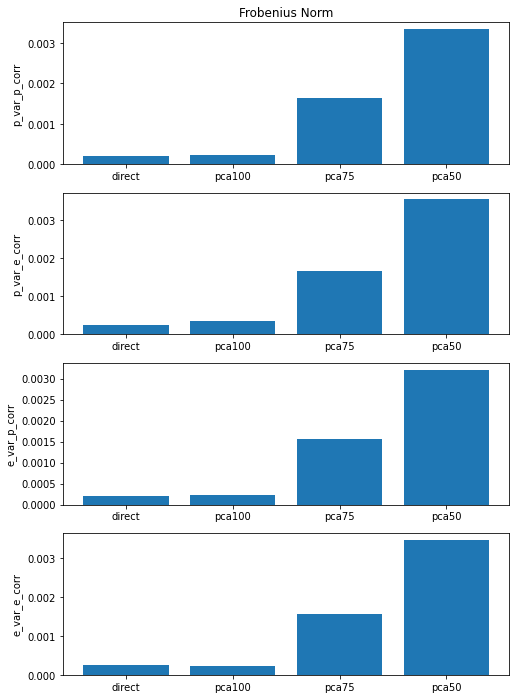

In [22]:
norm_d = []
norm_pca100 = []
norm_pca75 = []
norm_pca50 = []
time_d = []
time_pca100 = []
time_pca75 = []
time_pca50 = []

for cov in inputs:
  t0 = time.time()
  res_d = direct_simulation(cov)
  t1 = time.time()
  res_pca100 = pca_simulation(cov, 1)
  t2 = time.time()
  res_pca75 = pca_simulation(cov, 0.75)
  t3 = time.time()
  res_pca50 = pca_simulation(cov, 0.5)
  t4 = time.time()
  norm_d.append(frobenius_norm(np.cov(res_d) - cov))
  norm_pca100.append(frobenius_norm(np.cov(res_pca100) - cov))
  norm_pca75.append(frobenius_norm(np.cov(res_pca75) - cov))
  norm_pca50.append(frobenius_norm(np.cov(res_pca50) - cov))
  time_d.append(t1 - t0)
  time_pca100.append(t2 - t1)
  time_pca75.append(t3 - t2)
  time_pca50.append(t4 - t3)

plt.figure()
fig, axes = plt.subplots(4, 1, figsize=(8, 12))
labels = ['direct', 'pca100', 'pca75', 'pca50']
cov_names = ['p_var_p_corr', 'p_var_e_corr', 'e_var_p_corr', 'e_var_e_corr']
for i in range(len(labels)):
  axes[i].bar(labels, [norm_d[i], norm_pca100[i], norm_pca75[i], norm_pca50[i]])
  axes[i].set_ylabel(cov_names[i])
axes[0].set_title('Frobenius Norm')
plt.show()

<Figure size 432x288 with 0 Axes>

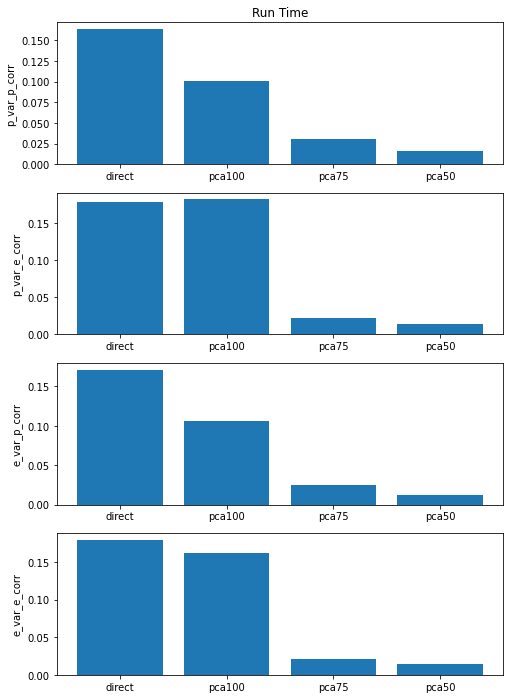

In [23]:
plt.figure()
fig, axes = plt.subplots(4, 1, figsize=(8, 12))
labels = ['direct', 'pca100', 'pca75', 'pca50']
cov_names = ['p_var_p_corr', 'p_var_e_corr', 'e_var_p_corr', 'e_var_e_corr']
for i in range(len(labels)):
  axes[i].bar(labels, [time_d[i], time_pca100[i], time_pca75[i], time_pca50[i]])
  axes[i].set_ylabel(cov_names[i])
axes[0].set_title('Run Time')
plt.show()

From the results above, we can see that using PCA with decreasing explained percentage, the accuracy becomes worse and worse, while the run time becomes faster and faster. The run time benefit increases slower than the accuracy losses, so that the gain of lowering the PCA explained percentage is not very high. Only do it when computational resource is really limited.